In [7]:
%matplotlib inline
import chainer
from chainer import optimizers
import numpy as np
import csv
import matplotlib.pyplot as plt
from net import Net

In [8]:
n_epoch = 200
batchsize = 100
bprop_len = 10
n_units = 30
grad_clip = 5
use_gpu = False

In [9]:
xp = cuda.cupy if use_gpu is True else np

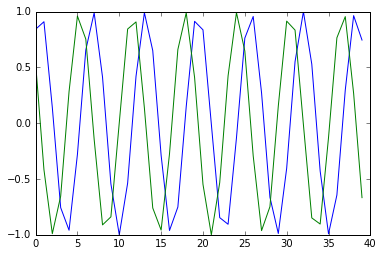

In [11]:
train_data_x = []
train_data_y = []
f = open('testdata.csv','r')
data = csv.reader(f, delimiter=',')
for row in data:
    train_data_x.append(row[1])
    train_data_y.append(row[2])
train_data_x = np.asarray(train_data_x, dtype=np.float32)
train_data_y = np.asarray(train_data_y, dtype=np.float32)
plt.plot(train_data_x[:40])
plt.plot(train_data_y[:40])

In [12]:
#ネットワークを試す関数
def evaluate(model,num,origin=0):
    t = chainer.Variable(xp.array([[origin]],dtype=np.float32))
    output = []
    evaluator = model.copy()
    evaluator.reset_state()
    for i in range(num):
        t = evaluator.predict(t)
        output.append(t.data[0])
    return output

In [13]:
model = Net(1, 10)#入力の次元数, 中間層の次元数
if use_gpu is True:
    model.to_gpu()
optimizer = optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
loss = []
length = len(train_data_x)
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
for i in range(jump * n_epoch):
    x = chainer.Variable(xp.asarray([[train_data_x[(jump * j + i) % length]] for j in batch_idxs]))
    y = chainer.Variable(xp.asarray([[train_data_y[(jump * j + i) % length]] for j in batch_idxs]))
    loss_i = model(x,y)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        #if epoch > 5:
        #    optimizer.lr /= 1.3
        print('epoch {}, error {}'.format(epoch, loss_data / length))
        loss.append(loss_data / length)
        loss_data = 0
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()

epoch 1, error 0.02964233136177063
epoch 2, error 0.02980940246582031
epoch 3, error 0.029625321865081787
epoch 4, error 0.02945579308271408
epoch 5, error 0.029300902843475342
epoch 6, error 0.029160234332084655
epoch 7, error 0.02903319174051285
epoch 8, error 0.028919049203395844
epoch 9, error 0.028816970229148864
epoch 10, error 0.028725994408130645
epoch 11, error 0.02864507782459259
epoch 12, error 0.0285730961561203
epoch 13, error 0.028508912563323975
epoch 14, error 0.028451373517513274
epoch 15, error 0.028399369657039642
epoch 16, error 0.02835183984041214
epoch 17, error 0.028307789564132692
epoch 18, error 0.028266330540180205
epoch 19, error 0.02822667109966278
epoch 20, error 0.02818813943862915
epoch 21, error 0.02815017408132553
epoch 22, error 0.02811231714487076
epoch 23, error 0.028074219703674318
epoch 24, error 0.028035623490810395
epoch 25, error 0.02799634522199631
epoch 26, error 0.027956277906894682
epoch 27, error 0.027915364742279052
epoch 28, error 0.02787

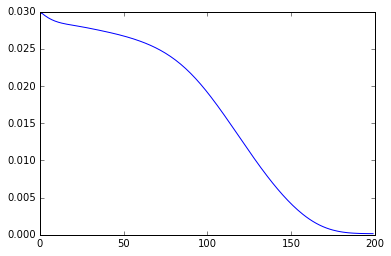

In [15]:
plt.plot(loss)

In [ ]:
output = evaluate(model,400,origin=0)
plt.plot(output[:100])